# Feature Analysis
----

<h4> Description </h4>
In this notebook I look for the best set of features. Also, the correlation between the feature is analysed. In particular I can understand the prediction by looking at how a feature impacts the base stellar mass of a giv

In [1]:
import numpy as np
import astropy.io.ascii as at
import scipy.stats as st
from astropy.table import Table, vstack, join
from astropy.io.fits import getdata

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import os

sns.set_style("whitegrid")
sns.set_context('talk',rc={"lines.linewidth": 2.5})

## Load Cosmos Sample

In [2]:
def transform_to_1d(x,y):
    ynew = y[:,0]
    xnew = np.vstack([x.T,y[:,1]]).T
    return xnew, ynew

In [3]:
path = '../data/'
x_train = np.load(path+'qf_x_train.npy')
y_train = np.load(path+'qf_y_train.npy')

x_test = np.load(path+'qf_x_test.npy')
y_test = np.load(path+'qf_y_test.npy')

# y_train_err = np.array(joined['smass_err'][joined['Train']])

In [4]:
x_test1d, y_test1d = transform_to_1d(x_test,y_test)
x_train1d, y_train1d = transform_to_1d(x_train,y_train)

In [5]:
x_train_small = x_train1d[:,4:]
x_test_small = x_test1d[:,4:]

## Cross Validation Sample

In [6]:
def convert_mag_to_fluxes(mag,f_o=10**12):
    return f_o*10.**(-mag/2.5)

def convert_mag_to_lupmag(mags, a=2.5*np.log10(np.exp(1)), f_o=10**12):
    # define quantities
    m_o = 2.5*np.log10(f_o)
    #mags = np.c_[g,r,i,z]
    fluxes = convert_mag_to_fluxes(mags)

    # sigma = 10**np.std(np.log10(fluxes),axis=0)
    sigma = np.array([28.79631884352346, 39.89162179800252, 67.37310780328083, 118.70759986796102]) # g,r,i,z
    b = np.sqrt(a)*sigma

    # define g,r,i,z fluxes as a numpy array
    # luptitudes and errors
    lups = (m_o - 2.5*np.log10(b)) - a*np.arcsinh(fluxes/(2*b))
    lup_errors = np.sqrt(((a**2) * (sigma**2)) / (4*(b**2) + (fluxes**2)))

    return lups, lup_errors

rsMean = np.load('../data/redSequence_deepField_mean_color.npy')
def get_input_galpro(mags, redshift, a=2.5*np.log10(np.exp(1)), f_o=10**12, normalize=False):
    # lupMags
    lups, lup_errors = convert_mag_to_lupmag(mags, a=a, f_o=f_o)
    g_r = lups[:, 0] - lups[:, 1]
    r_i = lups[:, 1] - lups[:, 2]
    i_z = lups[:, 2] - lups[:, 3]
    
    # red-sequence offset
    delta_gr = g_r - np.interp(redshift,rsMean[0],rsMean[1])
    delta_ri = r_i - np.interp(redshift,rsMean[0],rsMean[2])
    delta_iz = i_z - np.interp(redshift,rsMean[0],rsMean[3])
    
    if normalize:
        delta_gr /= np.interp(redshift,rsMean[0],rsMean[4])
        delta_ri /= np.interp(redshift,rsMean[0],rsMean[5])
        delta_iz /= np.interp(redshift,rsMean[0],rsMean[6])
        
    # colour errors
    g_r_err = ((lup_errors[:, 0]**2) + (lup_errors[:, 1]**2))**0.5
    r_i_err = ((lup_errors[:, 1]**2) + (lup_errors[:, 2]**2))**0.5
    i_z_err = ((lup_errors[:, 2]**2) + (lup_errors[:, 3]**2))**0.5
    
    # abs mag
    distMod = cosmo.distmod(redshift).value
    absMags = lups-distMod[:,np.newaxis]

    # combining everything
    x_target = np.c_[lups, delta_gr, delta_ri, delta_iz, lup_errors, g_r_err, r_i_err, i_z_err, redshift]
    return x_target

In [54]:
from astropy.cosmology import WMAP9 as cosmo
## load target data
fname = '../data/des_sdssGalexWISE_matched.csv'
data = at.read(fname)

mags = np.c_[[data['sof_cm_mag_corrected_%s'%bp_filter] for bp_filter in ['g','r','i','z']]].T
mags_err = np.c_[[data['sof_cm_mag_err_%s'%bp_filter] for bp_filter in ['g','r','i','z']]].T
mask= data['sdss_mass']>0.
ztrue= data['sdss_z']

x_target = get_input_galpro(mags[mask],ztrue[mask])

distMod = cosmo.distmod(ztrue[mask]).value
absMags = x_target[:,:4]-distMod[:,np.newaxis]
x_target1d = np.c_[x_target,absMags[:,3]]

y_target = np.array(data['sdss_mass'][mask])
x_target_small = x_target1d[:,4:]

# Feature Selection

In [163]:
feature_names = [r'mag_%s'%bpF for bpF in ['g','r','i','z']]
feature_names+= [r'(%s - %s)'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]
feature_names+= ['Mag_err_%s'%bpF for bpF in ['g','r','i','z']]
feature_names+= ['Err(%s - %s)'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]
feature_names+= ['redshift']
feature_names+= [r'M_z']
# feature_names

In [164]:
import pandas as pd
mydict = dict()
for i,col in enumerate(feature_names):
    mydict[col] = x_target1d[:,i]
    
df = pd.DataFrame(mydict)
df.head()

,mag_g,mag_r,mag_i,mag_z,(g - r),(r - i),(i - z),Mag_err_g,Mag_err_r,Mag_err_i,Mag_err_z,Err(g - r),Err(r - i),Err(i - z),redshift,M_z
0,17.400159,17.091227,16.982330,16.884993,-0.279142,-0.154166,-0.053445,0.000285,0.000297,0.000454,0.000731,0.000412,0.000543,0.000861,0.0622,-20.365166
1,17.728132,17.180753,16.878506,16.726703,0.013471,0.046919,0.026826,0.000386,0.000323,0.000413,0.000632,0.000503,0.000524,0.000755,0.1026,-21.671443
2,18.146212,17.140667,16.745011,16.451187,0.390692,0.131600,0.162621,0.000567,0.000311,0.000365,0.000491,0.000647,0.000480,0.000611,0.1716,-23.160715
3,17.745309,17.457481,17.377194,17.281343,-0.316603,-0.185111,-0.062725,0.000392,0.000416,0.000653,0.001054,0.000572,0.000775,0.001240,0.0281,-18.188934
4,18.364145,17.217043,16.749152,16.428986,0.484503,0.191011,0.180780,0.000693,0.000334,0.000366,0.000481,0.000769,0.000496,0.000604,0.1893,-23.419506


In [157]:
import xgboost

model = xgboost.XGBRegressor()
name = 'XGBoost'
X = x_target1d
y = y_target

ydf = pd.DataFrame({'M_star':y})

In [113]:
import time
def header(name):
    print(5*'-----')
    print('Machine Learning Training: %s'%name)

def fit(self,x,y):
    start_time = time.time()
    self.fit(x,y)
    self.elapsed_time = (time.time()-start_time)/60.
    print('Elapsed time: %.2f min'%self.elapsed_time)

header(name)
fit(model,df,ydf)
print('')

-------------------------
Machine Learning Training: XGBoost
Elapsed time: 0.04 min



In [159]:
import pandas as pd
mydict = dict()
mydict2= dict()
for i,col in enumerate(feature_names):
    mydict2[col] = x_target1d[:,i]
    mydict[col] = x_test1d[:,i]
    
df_test = pd.DataFrame(mydict)
df_test2= pd.DataFrame(mydict2)
df_test.head()

,mag_g,mag_r,mag_i,mag_z,(g - r),(r - i),(i - z),Mag_err_g,Mag_err_r,Mag_err_i,Mag_err_z,Err(g - r),Err(r - i),Err(i - z),redshift,M_z
0,23.257325,22.574959,22.150122,22.058887,0.682366,0.424837,0.091234,0.062577,0.046316,0.052861,0.085275,0.077853,0.070281,0.100330,0.5956,-20.525000
1,23.785520,22.803983,22.590498,22.331532,0.981537,0.213485,0.258966,0.101185,0.057133,0.079048,0.109137,0.116200,0.097533,0.134757,0.4963,-19.599001
2,20.958171,20.363225,20.084387,19.952375,0.594946,0.278838,0.132012,0.007556,0.006052,0.007906,0.012334,0.009681,0.009956,0.014650,0.2200,-19.938999
3,23.817212,23.202628,23.036072,23.031867,0.614584,0.166556,0.004204,0.104122,0.082211,0.118286,0.202116,0.132665,0.144049,0.234185,0.2801,-18.059999
4,23.996145,23.313104,23.082943,22.785801,0.683040,0.230161,0.297143,0.122295,0.090888,0.123359,0.163462,0.152370,0.153225,0.204786,0.7031,-19.164000


In [138]:
import shap

X_test = df_test
# get shap values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


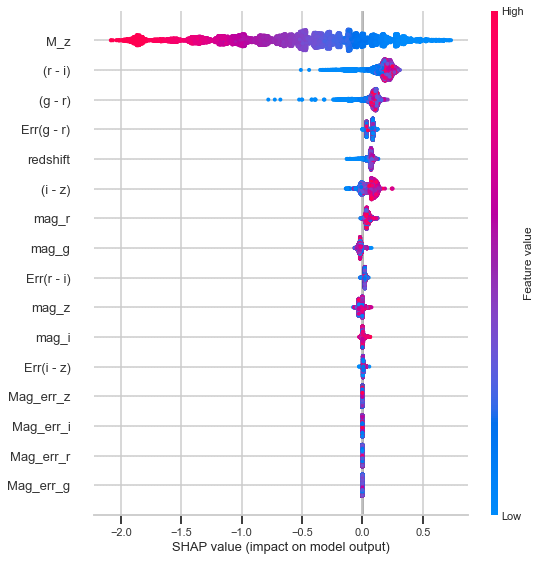

In [139]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

The colors, brightness and redshift shows as the most important featues as we expected.

## Color, Mz, redshift Model

In [165]:
feature_names_2 = [r'M_z']
feature_names_2+= [r'(%s - %s)'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]
feature_names_2+= ['redshift']
feature_names_2+= ['Mag_err_%s'%bpF for bpF in ['z']]
# feature_names

In [170]:
df_simple = df[feature_names_2].copy()
df_simple.head()

,M_z,(g - r),(r - i),(i - z),redshift,Mag_err_z
0,-20.365166,-0.279142,-0.154166,-0.053445,0.0622,0.000731
1,-21.671443,0.013471,0.046919,0.026826,0.1026,0.000632
2,-23.160715,0.390692,0.131600,0.162621,0.1716,0.000491
3,-18.188934,-0.316603,-0.185111,-0.062725,0.0281,0.001054
4,-23.419506,0.484503,0.191011,0.180780,0.1893,0.000481


In [171]:
df_test_simple = df_test[feature_names_2].copy()
df_test_simple2= df_test2[feature_names_2].copy()


In [172]:
header(name+' with Mz, colors, redshift')
fit(model,df_simple,ydf)
print('')

-------------------------
Machine Learning Training: XGBoost with Mz, colors, redshift
Elapsed time: 0.02 min



In [185]:
X_test = df_test_simple
# get shap values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


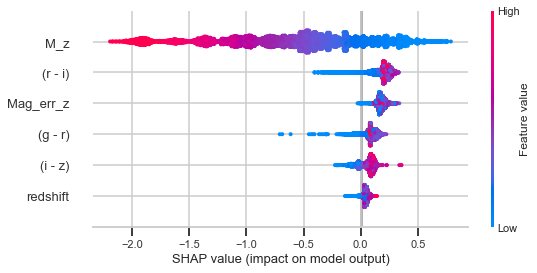

In [186]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

In [187]:
# visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[21,:], X_test.iloc[21,:])

This galaxy above is near the limit of the DES photometry. For $z=0.7$ a high stellar mass galaxy has a predicted value explained mainly by the red color and the brightness. The error on the magnitude also plays a role since we have a poorer photometry. 

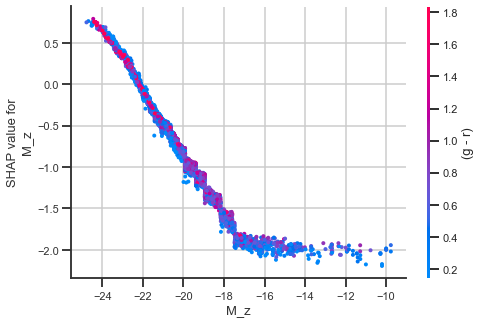

In [188]:
shap.dependence_plot("M_z", shap_values, X_test, interaction_index='(g - r)')

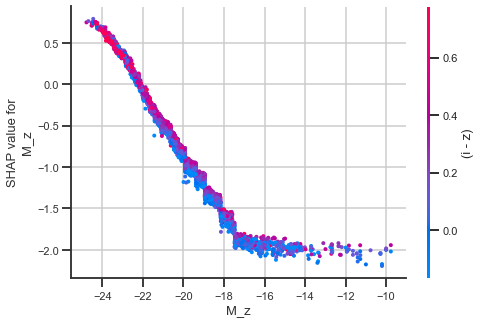

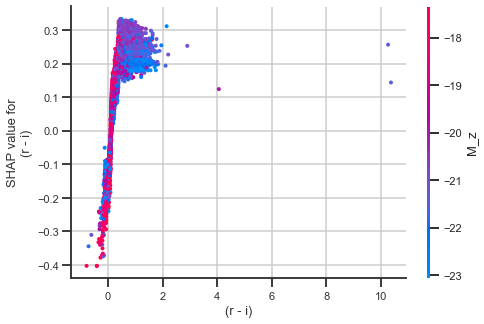

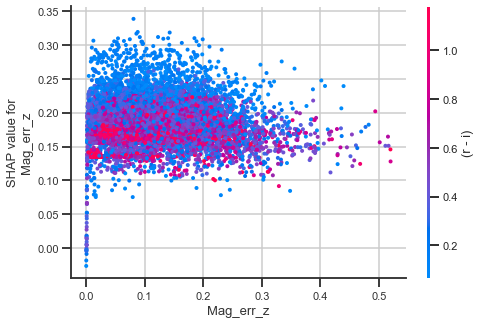

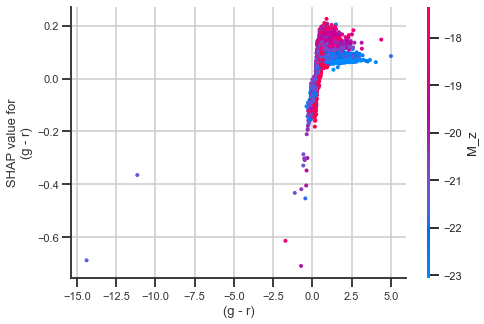

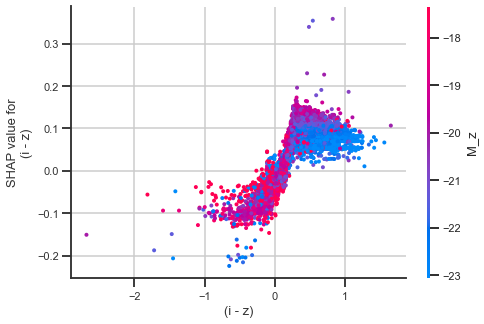

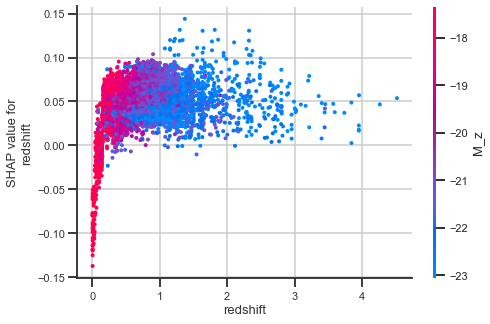

In [189]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(6):
    shap.dependence_plot(top_inds[i], shap_values, X_test)

The brightness add to the stellar mass base value only bright and redder objects. We nicely see the correlation between the colors. 

We see an issue with the very low redshift galaxies. The redshift makes the values of the less luminous galaxies a bit smaller, 0.05 dex. Let's understand how this impacts on a local volume sample.

## Testing on local Universe

In [190]:
X_test = df_test_simple2
# get shap values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


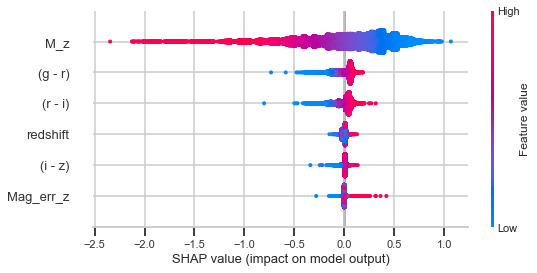

In [191]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

In [192]:
# visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[21,:], X_test.iloc[21,:])

This galaxy above is near the limit of the DES photometry. For $z=0.7$ a high stellar mass galaxy has a predicted value explained mainly by the red color and the brightness. The error on the magnitude also plays a role since we have a poorer photometry. 

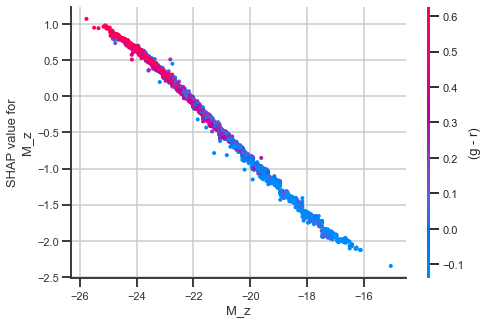

In [193]:
shap.dependence_plot("M_z", shap_values, X_test, interaction_index='(g - r)')

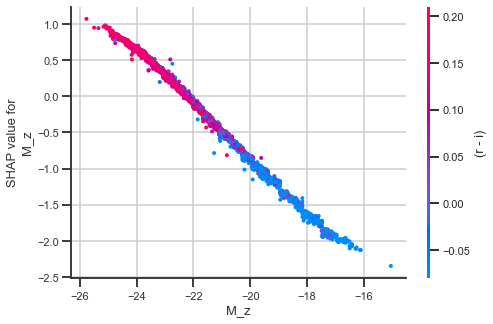

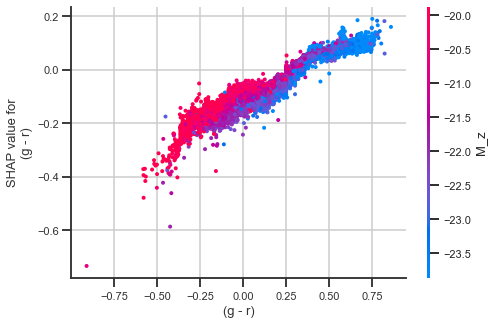

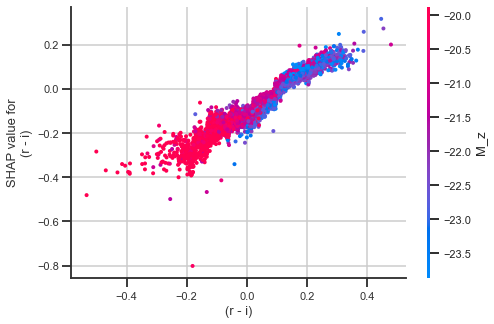

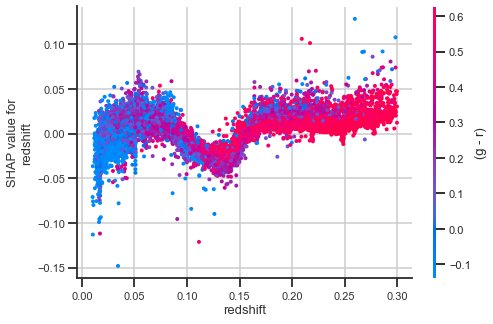

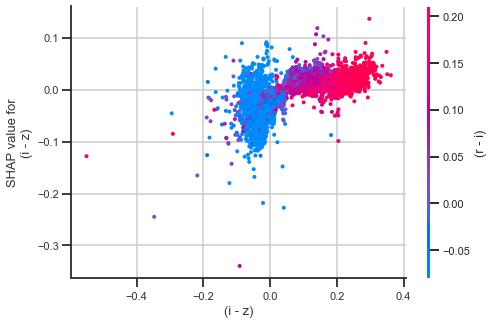

In [194]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(5):
    shap.dependence_plot(top_inds[i], shap_values, X_test)

We nicely see the correlation between the colors. The other thing that strikes is the redshift trend, there is a inflexion point. However the strength of this effect is below the accuracy of the predictions, 0.05 dex.